In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd

import datetime

import pickle

import wntr

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns

In [3]:
from src.config import config
from src.preprocess.config import NR_OF_LEAK_LOCS_MC_2
from src.datamatrix.config import PRESSURE_LOGGERS_KEEP_IN_DATAMAT
from src.experiments.helper_funcs import compute_mean_log_loss_over_leak_experiments

In [4]:
from src.visualization.wdn_fig_visualization import WDNLeakProbsFigBuilder

# Load data

In [5]:
data_dir = config.DATA_DIR
model_dir = config.MODEL_DIR
results_dir = config.RESULTS_DIR

#### Load trained leak localization models

In [6]:
leak_classification_model_dir = model_dir / "HPC_run_04/leak_classification/trained_on_data/experiment_00"
log_reg_models_trained_file_name = leak_classification_model_dir / "log_reg_models_trained.p"
log_reg_models_trained = pickle.load( open( log_reg_models_trained_file_name, "rb" ) )

#### Load test data matrices

In [7]:
processed_data_dir = data_dir / "processed/HPC_run_04/experiment_00"

X_test_per_leak_exp_file_name = processed_data_dir / "X_test_per_leak_exp.p"
X_test_per_leak_exp = pickle.load( open( X_test_per_leak_exp_file_name, "rb" ) )

y_test_per_leak_exp_file_name = processed_data_dir / "y_test_per_leak_exp.p"
y_test_per_leak_exp = pickle.load( open( y_test_per_leak_exp_file_name, "rb" ) )

#### Load network info

In [8]:
simulations_input_dir = data_dir / "input/BKTown/HPC_run_04/"

In [9]:
inp_file_name = simulations_input_dir / "BKTown_extended_WDN_01Jul2020_31Aug2020_calibrated.inp"
wn = wntr.network.WaterNetworkModel(inp_file_name=inp_file_name)

In [10]:
pressure_loggers_asset_id_file = simulations_input_dir / "pressure_loggers_asset_id.csv"
pressure_loggers_asset_id = pd.read_csv(pressure_loggers_asset_id_file, dtype=str)

hydrants_asset_id_file = simulations_input_dir / "hydrants_asset_id.csv"
hydrants_asset_id = pd.read_csv(hydrants_asset_id_file, dtype=str)

#### Load leak information, only experiments with leak size of 10 m3/h are considered

In [11]:
measured_data_dir = data_dir / "raw/BKTown/experiments/"

infield_logging_file = measured_data_dir / "infield_logging_leaks_10_m3h.csv"
exp_leaks_info = pd.read_csv(infield_logging_file , dtype=str)

#### Define leak candidates

In [12]:
#hydrant asset id's are the leak candidates
all_leak_locs = list(hydrants_asset_id['G3E_FID'])

#### Define pressure loggers

In [13]:
all_pressure_loggers = list(pressure_loggers_asset_id['asset_id'])

#### Info on leak experiments

In [14]:
exp_leaks_info['start_leak_datetime'] = pd.to_datetime(exp_leaks_info['Datum'] +' ' + exp_leaks_info['Beginuur'],
                                                       format="%d/%m/%Y %H:%M")
exp_leaks_info['end_leak_datetime'] = pd.to_datetime(exp_leaks_info['Datum'] +' ' + exp_leaks_info['Einduur'],
                                                       format="%d/%m/%Y %H:%M")
exp_leaks_info.drop(['Datum','Beginuur','Einduur'], axis='columns', inplace=True)

In [221]:
leak_locs_experiments

['775125', '773051', '780176', '936678', '2288126', '1164867', '1135282']

# Test leak localization per leak experiment

In [15]:
hydrants_nb_to_label_dict = dict(zip(all_leak_locs, np.arange(0,len(all_leak_locs))))

#### Evaluate log loss over the hyperparameters

In [16]:
Cs = [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1]
l1_ratios = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]

#Cs = [1e0]
#l1_ratios = [0.0]

In [17]:
log_reg_models_log_loss = {}

for l1_ratio in l1_ratios:
    log_reg_models_log_loss[str(l1_ratio)] = {}
    
    for C in Cs:
        log_reg_models_log_loss[str(l1_ratio)][str(C)] = {}
        trained_models_per_leak_exp = log_reg_models_trained[str(l1_ratio)][str(C)]

        log_loss_mean = compute_mean_log_loss_over_leak_experiments(trained_models_per_leak_exp.keys(),
                                                                    X_test_per_leak_exp,
                                                                    trained_models_per_leak_exp,
                                                                    hydrants_nb_to_label_dict,
                                                                    NR_OF_LEAK_LOCS_MC_2)
            
        log_reg_models_log_loss[str(l1_ratio)][str(C)] = log_loss_mean

#### Plot cross entropy results for L2 logistic regression

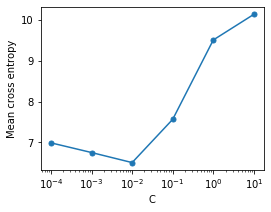

In [18]:
tmp = list(log_reg_models_log_loss['0.0'].keys())
x_values = [float(loss) for loss in tmp]
y_values = list(log_reg_models_log_loss['0.0'].values())

fig = plt.figure(figsize=(4, 3))

plt.plot(x_values, y_values, marker = ".", markersize=10)
plt.xscale('log')
plt.xlabel('C')
plt.ylabel('Mean cross entropy')
plt.show()

#fig_dir = results_dir / "BKTOWN/experiment_00"
#fig_file_name = fig_dir / "log_reg_l2_C_search_result.pdf"
#fig.savefig(fig_file_name, bbox_inches='tight')

#### Plot cross entropy results for Elastic-Net logistic regression

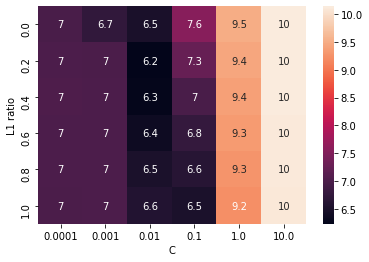

In [21]:
log_reg_models_log_loss_df = pd.DataFrame(log_reg_models_log_loss)
ax = sns.heatmap(log_reg_models_log_loss_df.T, annot=True)
ax.set(xlabel='C', ylabel='L1 ratio')

#fig_file_name = fig_dir / "log_reg_elastic_C_l1_search_result.pdf"
#plt.savefig(fig_file_name)

#### Visualize leak probabilities

In [215]:
l1_ratio_plot = '0.2'
C_plot = '0.01'
leak_exp_idx_plot = 6

In [216]:
leak_locs_experiments

['775125', '773051', '780176', '936678', '2288126', '1164867', '1135282']

In [217]:
models_trained_per_leak_exp = log_reg_models_trained[l1_ratio_plot][C_plot]

leak_locs_experiments = list(models_trained_per_leak_exp.keys())

leak_loc_true = leak_locs_experiments[leak_exp_idx_plot]
leak_start_datetime = exp_leaks_info[exp_leaks_info['3GE FID'] == leak_loc_true]['start_leak_datetime']
leak_start_datetime = str(pd.to_datetime(leak_start_datetime.values[0]))

# X test vector for the leak location
X_real_test = X_test_per_leak_exp[leak_loc_true]

# Compute leak probabilities for the classifier
clf = models_trained_per_leak_exp[leak_loc_true]
y_probs_log_reg_real = clf.predict_proba(X_real_test).reshape((1,1,NR_OF_LEAK_LOCS_MC_2))
y_probs_plot = y_probs_log_reg_real.flatten()

In [218]:
wdn_leak_probs_fig_builder = WDNLeakProbsFigBuilder(wn,
                                                    leak_start_datetime,
                                                    [],
                                                    all_leak_locs,
                                                    leak_loc_true,
                                                    hydrants_nb_to_label_dict,
                                                    y_probs_plot,
                                                    leak_probs_color_map_scaling = 'linear_set_max',
                                                    leak_probs_color_map_max_bound=0.004,
                                                    show_other_nodes_than_hydrant=False,
                                                    fig_legend_font_size=1)
wdn_leak_probs_fig_builder.build_wdn_fig()
wdn_fig = wdn_leak_probs_fig_builder.wdn_fig
#wdn_fig.show()